# NLP Answers

- **Answer Set**: No. 02
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [33]:
import warnings

import re as re

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import sklearn.base as skbase
import sklearn.utils as skutils
import sklearn.pipeline as skpipeline
import sklearn.preprocessing as skprocessing
import sklearn.model_selection as skselection
import sklearn.feature_extraction.text as sktext

import hmm.hmm as hmm

warnings.filterwarnings("ignore", category=UserWarning)
sk.set_config(display="diagram")

### Dataset

Now we will load `hmm_data` corpus and store `TestSet` and `TrainSet`:

In [34]:
train_features = []
train_lengths = []
for i in range(5):
    data_set = pd.read_csv(
        f"../lib/hmm_data/seq_model_0{i+1}.txt", header=None, names=["Text"]
    ).applymap(lambda x: list(x)).to_numpy().flatten()
    data_features = np.concatenate(data_set)
    train_features.append(skprocessing.LabelEncoder().fit(data_features).transform(data_features))
    train_lengths.append(np.array([len(x) for x in data_set]))

test_features = []
test_lengths = []
for i in range(2):
    data_set = pd.read_csv(
        f"../lib/hmm_data/testing_data{i+1}.txt", header=None, names=["Text"]
    ).applymap(lambda x: list(x)).to_numpy().flatten()
    data_features = np.concatenate(data_set)
    test_features.append(skprocessing.LabelEncoder().fit(data_features).transform(data_features))
    test_lengths.append(np.array([len(x) for x in data_set]))

test_answers = pd.read_csv(
    f"../lib/hmm_data/testing_answer.txt", header=None, names=["Text"]
).to_numpy().flatten()

---

## Problem

Now, we will use the implemented `HMM` class and build **5** models based on **5** training sets, then we will iteratively train our models and calculate accuracies:

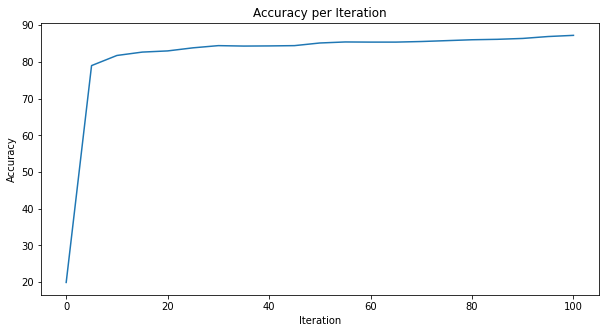

In [35]:
models = [hmm.load_model("../lib/hmm_data/model_init.txt") for _ in range(5)]
accuracies = []

for k in range(21):
    scores = []
    for i in range(5):
        if k > 0:
            models[i].fit(train_features[i], train_lengths[i])
        scores.append(models[i].score(test_features[0], test_lengths[0]))
    
    corrects = 0
    for index, model_index in enumerate(np.argmax(np.array(scores), axis=0)):
        if test_answers[index] == f"model_0{model_index+1}.txt":
            corrects += 1

    accuracies.append(corrects / 25)
    
plt.figure(figsize=(10, 5))
plt.plot([i*5 for i in range(21)], accuracies)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy per Iteration")
plt.show()

As we can see, after `100` iterations, the accuracy of models is about `87%`.

---